# Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## План выполнения работы

1 Импорт данных и первичных библиотек для анализа работы. Уточнение у заказчика метрики качества и ожидания от конечного результата.

2 Визуальная оценка данных:
* Выявление количества пропусков. 
* Построение корреляционных таблиц.

2 Предподготовка данных:
* Избавление от пропусков.
* Выявление важнейших признаков для построения модели.
* Соединение таблиц.
* Устранение мультиколлиниарности.

3 Обучение модели при помощи DecisionTreeRegressor, RandomForestRegressor, LinealRegression, CatBoost:
* использование инструмента optuna для подбора гиперпараметров параметров.
* Сравнение качества моделей.
* Исследование важности признаков.

4 Тестирование модели на тестовой выборке у лучшей модели

5 Отчёт о проделанной работе


Дополнительные вопросы:
Вопросов нет

# Исследование данных

In [38]:
# базовые библиотека
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# кодирование и масштабирование
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
import optuna

# цвет текста
from IPython.core.display import display, HTML

#Модели обучения
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 20220809

In [39]:
try:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [40]:
def data_info(df):
    """Функция первичного знакомства с данными"""
    display(df.head(10))
    print('Общая информация:')
    display(df.info())
    print('Общая статистика:')
    display(df.describe())
    print('Дубликаты:')
    display(df.duplicated().sum())
    print('Пропуски:')
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        print('{} - {}%'.format(col, round(pct_missing*100,2)))
    print('Матрица диаграмм:')
    pd.plotting.scatter_matrix(df,figsize=(10,10))
    plt.suptitle("Матрица диаграмм зависимостей", size=20)
    plt.show()
    print('Heatmap корреляций:')
    plt.figure(figsize=(10, 10))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
    plt.show()
    print('Boxblot для оценки выбросов:')
    df.drop(columns='key').plot(kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 10)
    )

    # increase spacing between subplots
    plt.subplots_adjust(wspace=0.8) 
    plt.show()

In [41]:
data_arc = data_arc.select_dtypes(include=['float64', 'int64']).copy()
data_bulk = data_bulk.select_dtypes(include=['float64', 'int64']).copy()
data_bulk_time = data_bulk_time.select_dtypes(include=['float64', 'int64']).copy()
data_gas = data_gas.select_dtypes(include=['float64', 'int64']).copy()
data_wire = data_wire.select_dtypes(include=['float64', 'int64']).copy()
data_wire_time = data_wire_time.select_dtypes(include=['float64', 'int64']).copy()
data_list = [data_arc, data_bulk, data_gas, data_temp, data_wire]

key  Активная мощность  Реактивная мощность
0    1           0.976059             0.687084
1    1           0.805607             0.520285
2    1           0.744363             0.498805
3    1           1.659363             1.062669
4    1           0.692755             0.414397
5    2           0.438063             0.283043
6    2           1.296415             0.892914
7    2           0.490377             0.305281
8    2           0.827743             0.516874
9    3           1.062053             0.671494

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  14876 non-null  int64  
 1   Активная мощность    14876 non-null  float64
 2   Реактивная мощность  14876 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 348.8 KB


None

Общая статистика:


key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

Дубликаты:


0

Пропуски:
key - 0.0%
Активная мощность - 0.0%
Реактивная мощность - 0.0%
Матрица диаграмм:


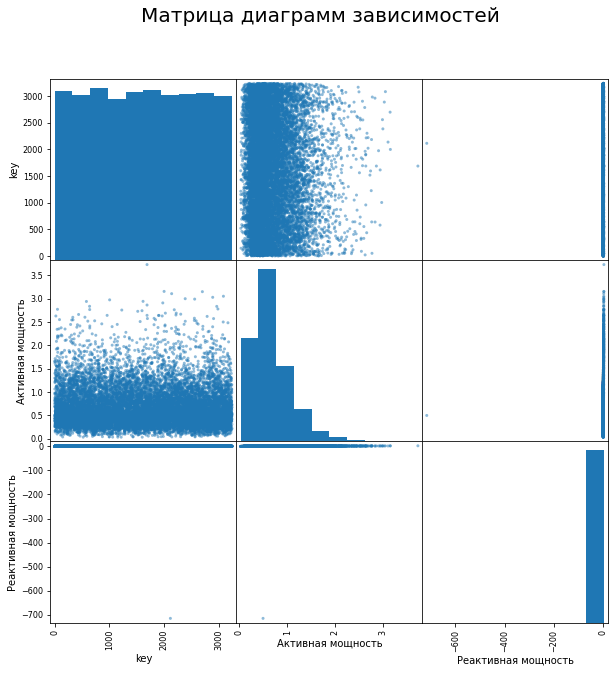

Heatmap корреляций:


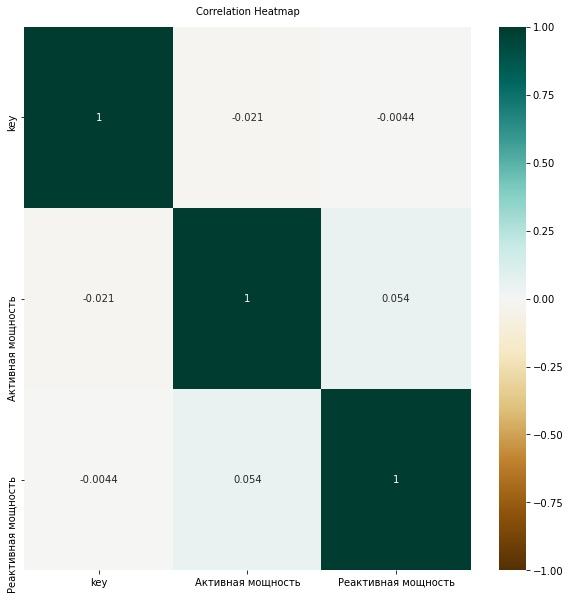

Boxblot для оценки выбросов:


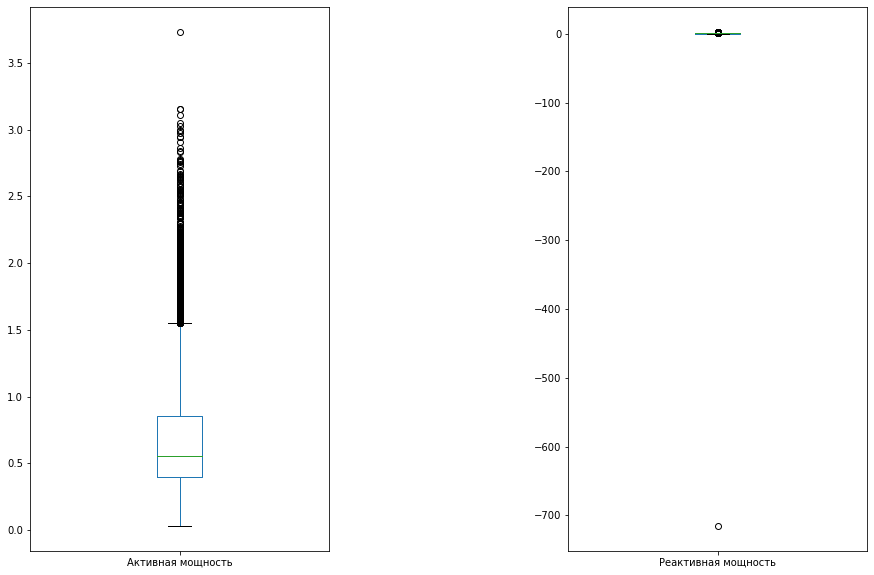

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Общая статистика:


key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Дубликаты:


0

Пропуски:
key - 0.0%
Bulk 1 - 91.95%
Bulk 2 - 99.3%
Bulk 3 - 58.52%
Bulk 4 - 67.59%
Bulk 5 - 97.54%
Bulk 6 - 81.59%
Bulk 7 - 99.2%
Bulk 8 - 99.97%
Bulk 9 - 99.39%
Bulk 10 - 94.38%
Bulk 11 - 94.34%
Bulk 12 - 21.7%
Bulk 13 - 99.42%
Bulk 14 - 10.32%
Bulk 15 - 28.16%
Матрица диаграмм:


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:89: UserWarning: Attempting to set identical left == right == 49.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:90: UserWarning: Attempting to set identical bottom == top == 49.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 49.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


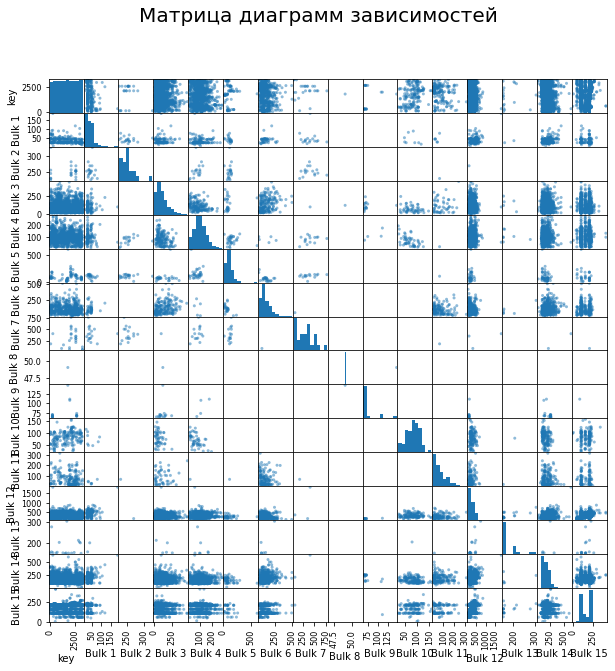

Heatmap корреляций:


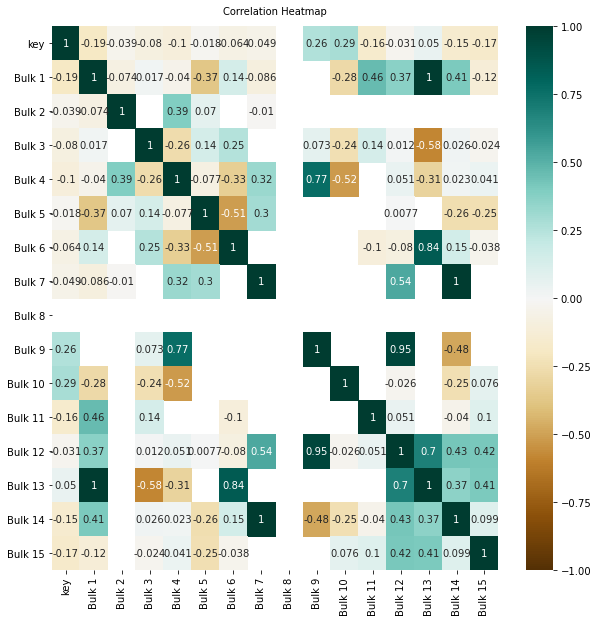

Boxblot для оценки выбросов:


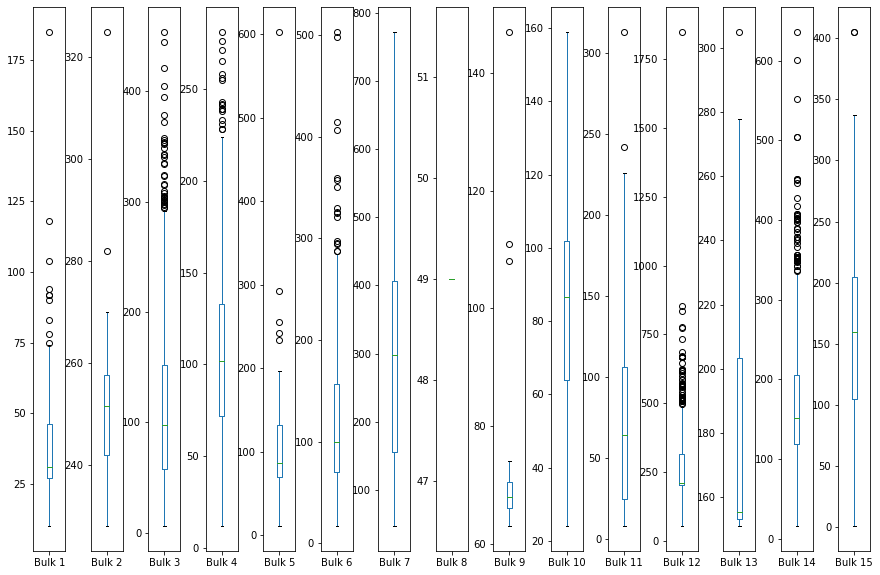

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Общая статистика:


key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Дубликаты:


0

Пропуски:
key - 0.0%
Газ 1 - 0.0%
Матрица диаграмм:


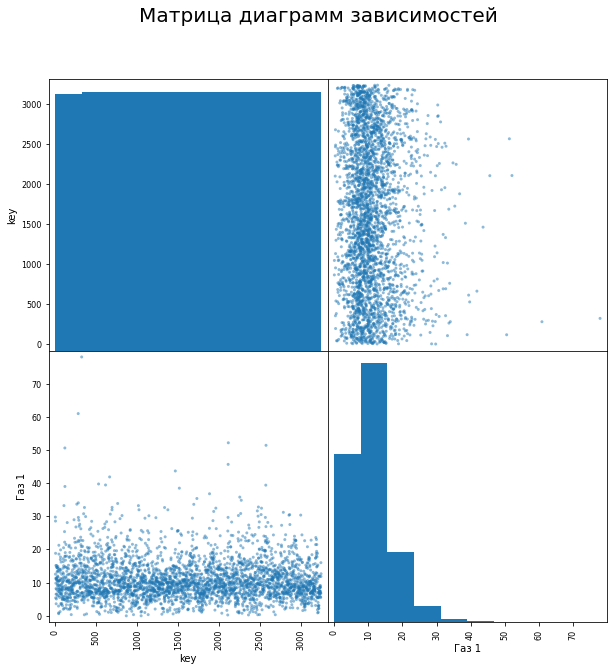

Heatmap корреляций:


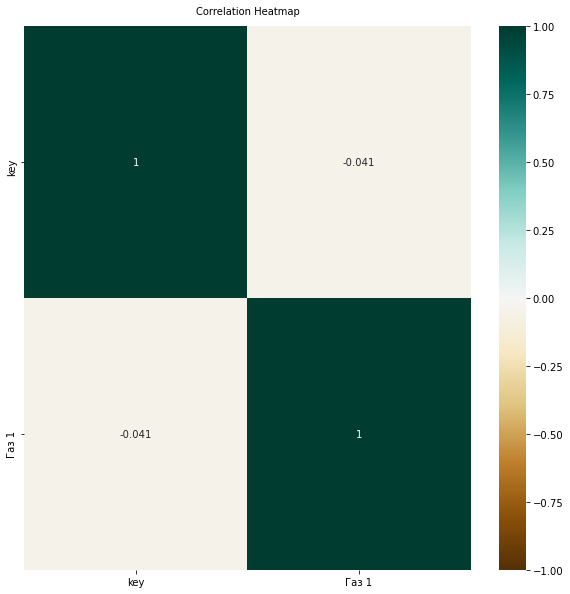

Boxblot для оценки выбросов:


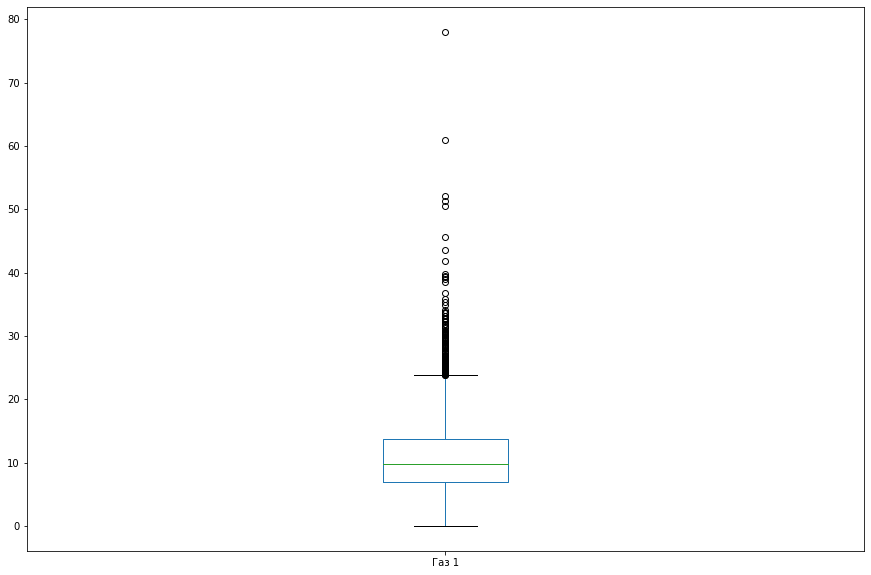

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
5    2  2019-05-03 11:37:27       1581.0
6    2  2019-05-03 11:38:00       1577.0
7    2  2019-05-03 11:49:38       1589.0
8    2  2019-05-03 11:55:50       1604.0
9    2  2019-05-03 11:58:24       1608.0

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Общая статистика:


key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Дубликаты:


0

Пропуски:
key - 0.0%
Время замера - 0.0%
Температура - 18.24%
Матрица диаграмм:


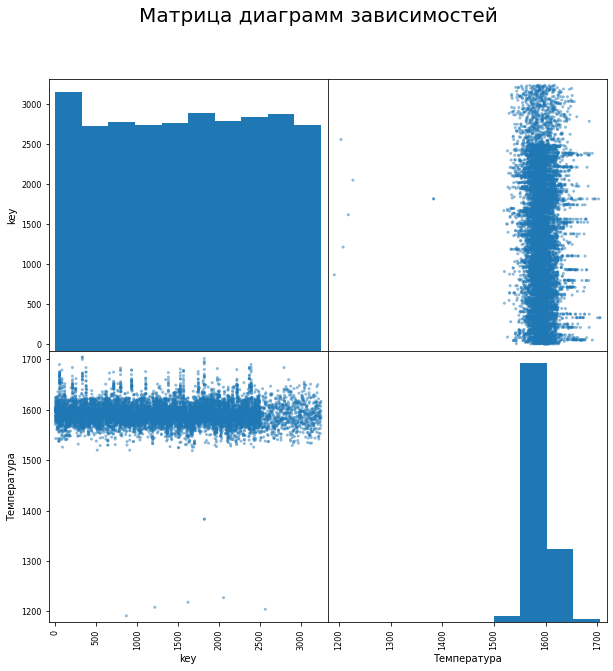

Heatmap корреляций:


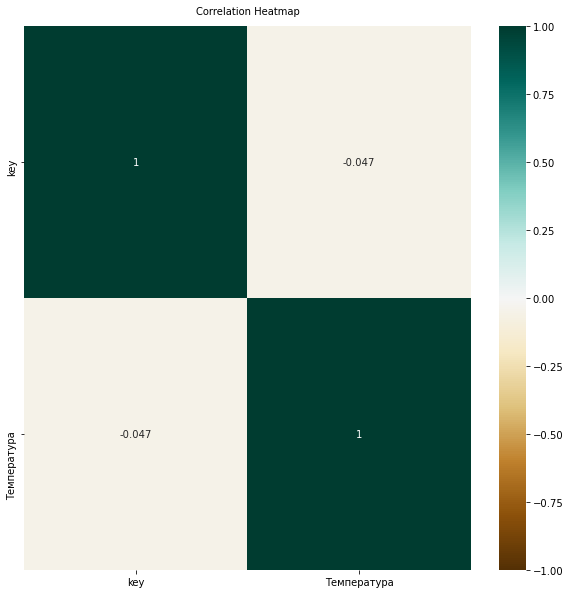

Boxblot для оценки выбросов:


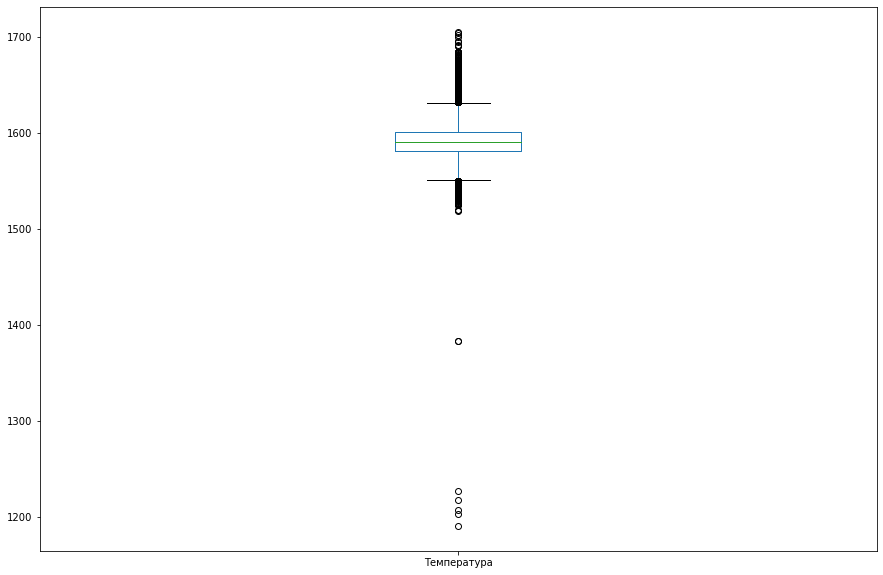

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Общая статистика:


key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

Дубликаты:


0

Пропуски:
key - 0.0%
Wire 1 - 0.84%
Wire 2 - 64.98%
Wire 3 - 97.96%
Wire 4 - 99.55%
Wire 5 - 99.97%
Wire 6 - 97.63%
Wire 7 - 99.64%
Wire 8 - 99.38%
Wire 9 - 99.06%
Матрица диаграмм:


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:89: UserWarning: Attempting to set identical left == right == 15.132 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:90: UserWarning: Attempting to set identical bottom == top == 15.132 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 15.132 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


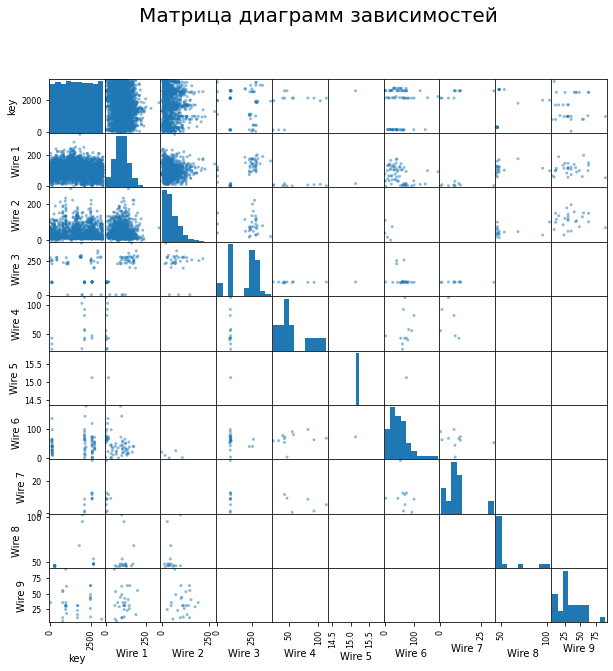

Heatmap корреляций:


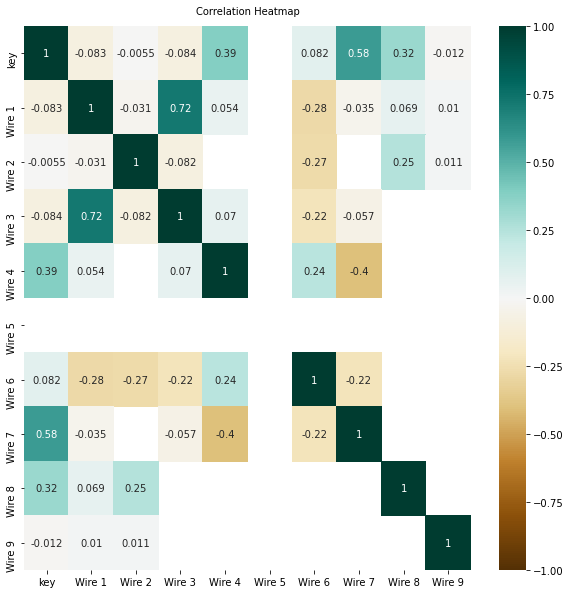

Boxblot для оценки выбросов:


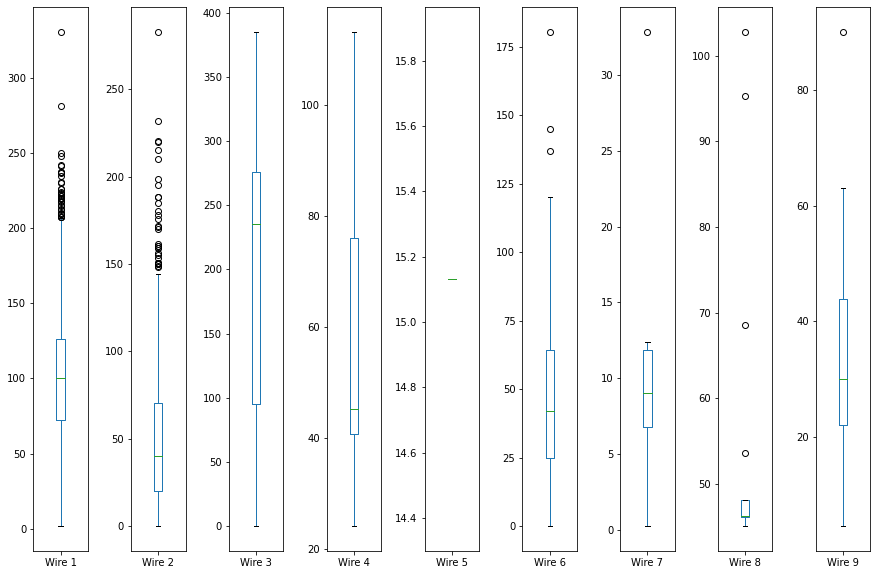

In [42]:
# выводим всё информацию о таблицах используя функцию data_info()
for i in data_list:
    
    data_info(i)

## Работа с пропусками

In [43]:
def pct_missing(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        print('{} - {}%'.format(col, round(pct_missing*100,2)))

In [44]:
# количество пропусков по столбцам в каждой таблице
n = 1
for i in data_list:
    
    print(f"Таблица {n}")
    pct_missing(i)
    n += 1

Таблица 1
key - 0.0%
Активная мощность - 0.0%
Реактивная мощность - 0.0%
Таблица 2
key - 0.0%
Bulk 1 - 91.95%
Bulk 2 - 99.3%
Bulk 3 - 58.52%
Bulk 4 - 67.59%
Bulk 5 - 97.54%
Bulk 6 - 81.59%
Bulk 7 - 99.2%
Bulk 8 - 99.97%
Bulk 9 - 99.39%
Bulk 10 - 94.38%
Bulk 11 - 94.34%
Bulk 12 - 21.7%
Bulk 13 - 99.42%
Bulk 14 - 10.32%
Bulk 15 - 28.16%
Таблица 3
key - 0.0%
Газ 1 - 0.0%
Таблица 4
key - 0.0%
Время замера - 0.0%
Температура - 18.24%
Таблица 5
key - 0.0%
Wire 1 - 0.84%
Wire 2 - 64.98%
Wire 3 - 97.96%
Wire 4 - 99.55%
Wire 5 - 99.97%
Wire 6 - 97.63%
Wire 7 - 99.64%
Wire 8 - 99.38%
Wire 9 - 99.06%


Т.К. Если знаение в таблицах data_bulk и data_wire равно NaN значит примесей не добавляли, следовательно можем заменить эти пропуски 0

### Генерация признаков в таблицах data_bulk и data_wire

In [45]:
data_bulk['count bulk'] = data_bulk.count(axis=1)
data_wire['count wire'] = data_wire.count(axis=1)
data_wire['sum wire'] = data_wire.drop(columns='count wire').sum(axis=1)

In [46]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)
data_list = [data_arc, data_bulk, data_gas, data_temp, data_wire]

In [47]:
# удалим колонки с более чем 30% пропусков
def del_col(df):
    dropped_col = []
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        if pct_missing > 0.30:
            dropped_col.append(col)
            
            
    return df.drop(columns=(dropped_col), inplace=True)

In [48]:
# удалим пропуски используя функцию del_col()
for i in data_list:
    i = del_col(i)

In [49]:
# количество пропусков по столбцам в каждой таблице
n = 1
for i in data_list:
    print(f"Таблица {n}")
    pct_missing(i)
    n += 1

Таблица 1
key - 0.0%
Активная мощность - 0.0%
Реактивная мощность - 0.0%
Таблица 2
key - 0.0%
Bulk 1 - 0.0%
Bulk 2 - 0.0%
Bulk 3 - 0.0%
Bulk 4 - 0.0%
Bulk 5 - 0.0%
Bulk 6 - 0.0%
Bulk 7 - 0.0%
Bulk 8 - 0.0%
Bulk 9 - 0.0%
Bulk 10 - 0.0%
Bulk 11 - 0.0%
Bulk 12 - 0.0%
Bulk 13 - 0.0%
Bulk 14 - 0.0%
Bulk 15 - 0.0%
count bulk - 0.0%
Таблица 3
key - 0.0%
Газ 1 - 0.0%
Таблица 4
key - 0.0%
Время замера - 0.0%
Температура - 18.24%
Таблица 5
key - 0.0%
Wire 1 - 0.0%
Wire 2 - 0.0%
Wire 3 - 0.0%
Wire 4 - 0.0%
Wire 5 - 0.0%
Wire 6 - 0.0%
Wire 7 - 0.0%
Wire 8 - 0.0%
Wire 9 - 0.0%
count wire - 0.0%
sum wire - 0.0%


In [50]:
# исследуем процент потерянных данных после группировки таблицы с целевым признаком
print(data_temp.groupby(by='key').agg('max').shape[0])
print(data_temp[data_temp['Температура'].isna()].groupby(by='key').agg('max').shape[0])

print(f"Процент удалённых данных {round((data_temp[data_temp['Температура'].isna()].groupby(by='key').agg('max').shape[0] * 100 / data_temp.groupby(by='key').agg('max').shape[0]), 2)} %")

3216
739
Процент удалённых данных 22.98 %


In [51]:
# Добавили колонку продолжительности измерений в секундах
time_min_max = data_temp.groupby(by=['key']).agg({'Время замера':('min','max')})
time_gap = (pd.to_datetime(time_min_max[('Время замера', 'max')]) - pd.to_datetime(time_min_max[('Время замера', 'min')])) / np.timedelta64(1, 's')
time_gap = time_gap.reset_index()


In [52]:
# Достали целевой признак и очистили данные
data_temp['rank'] = data_temp['key'].rank(method='first')
max_rank = list(data_temp.groupby(by=['key'])['rank'].agg('max'))
min_rank = list(data_temp.groupby(by=['key'])['rank'].agg('min'))
count_temp = data_temp[['key', 'Температура']].groupby(by=['key']).agg('count')
first_temp = data_temp.query("rank in @min_rank").dropna(subset=['Температура']).copy()[['key','Температура']]
first_temp.columns = ['key', 'Первая температура']

In [53]:
first_temp

key  Первая температура
0         1              1571.0
5         2              1581.0
11        3              1596.0
16        4              1601.0
19        5              1576.0
...     ...                 ...
15878  3237              1569.0
15883  3238              1584.0
15886  3239              1598.0
15894  3240              1617.0
15902  3241              1586.0

[3216 rows x 2 columns]

In [54]:
# добавили новый признак "Количество измерений до финального"
data_temp = pd.merge(data_temp, count_temp, how='inner', on='key')
data_temp = pd.merge(data_temp, first_temp, how='inner', on='key') 
data_temp = pd.merge(data_temp, time_gap, how='inner', on='key') 

data_temp.columns = ['key', 'Время замера', 'Температура', 'rank', 'Колличество измерений', 'Первое измерение', 'Продолжительность измерений']

# выделили целевой признак (финальное и первое измерение температуры)
data_temp = data_temp.query("rank in @max_rank").dropna(subset=['Температура']).copy()[['key', 'Температура', 'Колличество измерений', 'Первое измерение', 'Продолжительность измерений']]



In [55]:
data_temp

key  Температура  Колличество измерений  Первое измерение  \
4         1       1613.0                      5            1571.0   
10        2       1602.0                      6            1581.0   
15        3       1599.0                      5            1596.0   
18        4       1625.0                      3            1601.0   
20        5       1602.0                      2            1576.0   
...     ...          ...                    ...               ...   
12252  2495       1591.0                      3            1570.0   
12256  2496       1591.0                      4            1554.0   
12258  2497       1589.0                      2            1571.0   
12263  2498       1594.0                      5            1591.0   
12266  2499       1603.0                      3            1569.0   

       Продолжительность измерений  
4                            861.0  
10                          1305.0  
15                          1300.0  
18                           388.0  
20                           762.0  
...                            ...  
12252                       1137.0  
12256                       1618.0  
12258                        717.0  
12263                       1302.0  
12266                       1203.0  

[2477 rows x 5 columns]

Потери целевой переменной 22.9%. Очень высокий процент. Потенциально с такими проблемами идём к поставщику данных, т.к. это наш целевой признак и влиять на него мы не можем. В рамках проекта оставляем как есть.

## Работа с выбросами

Проверим на выбросы единственную колонку пригодную для этого исследования data_arc. Т.к. в таблицах с примесями значения заменены на 0 и картина графика искажена.

In [56]:
def blowouts(df):
    df.drop(columns='key').plot(kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 10)
    )

    # increase spacing between subplots
    plt.subplots_adjust(wspace=0.8) 
    plt.show()

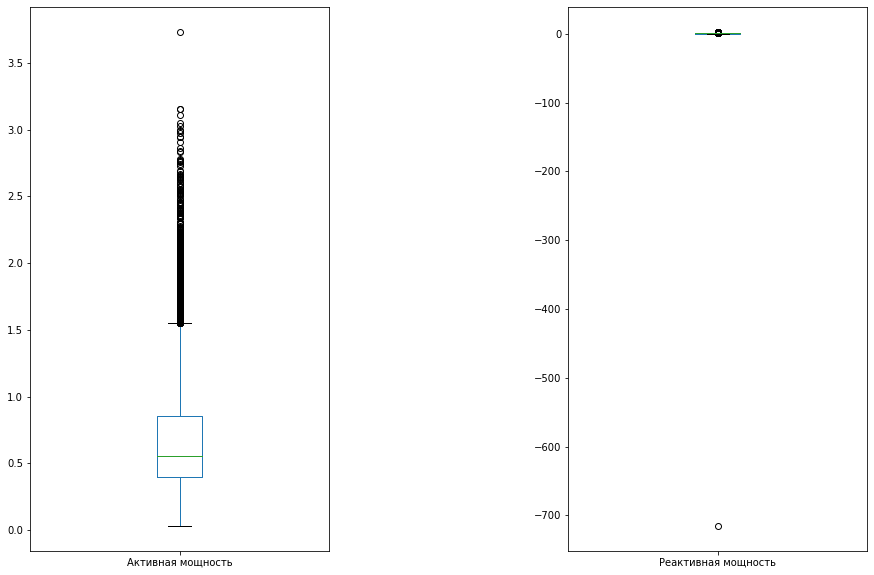

In [57]:
blowouts(data_arc)

In [58]:
# уберём критичные выбросы
data_arc = data_arc[(data_arc['Активная мощность'] < 3.5) & (data_arc['Реактивная мощность'] > -600)]

## Генерация признаков

По формуле полной мощности создадим новый признак в таблице data_arc

### Доля реактивной мощности, Разность мощностей

In [59]:
data_arc['Доля реактивной мощности'] = data_arc['Реактивная мощность'] * 100 / data_arc[['Активная мощность', 'Реактивная мощность']].sum(axis=1)
data_arc['Разность мощностей'] = abs(data_arc['Активная мощность'] - data_arc['Реактивная мощность'])

data_arc = data_arc.drop(columns=['Активная мощность', 'Реактивная мощность']).copy()

<ipython-input-59-5008d22f49a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['Доля реактивной мощности'] = data_arc['Реактивная мощность'] * 100 / data_arc[['Активная мощность', 'Реактивная мощность']].sum(axis=1)
<ipython-input-59-5008d22f49a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['Разность мощностей'] = abs(data_arc['Активная мощность'] - data_arc['Реактивная мощность'])


### Выброс/не выброс в колонке data_temp

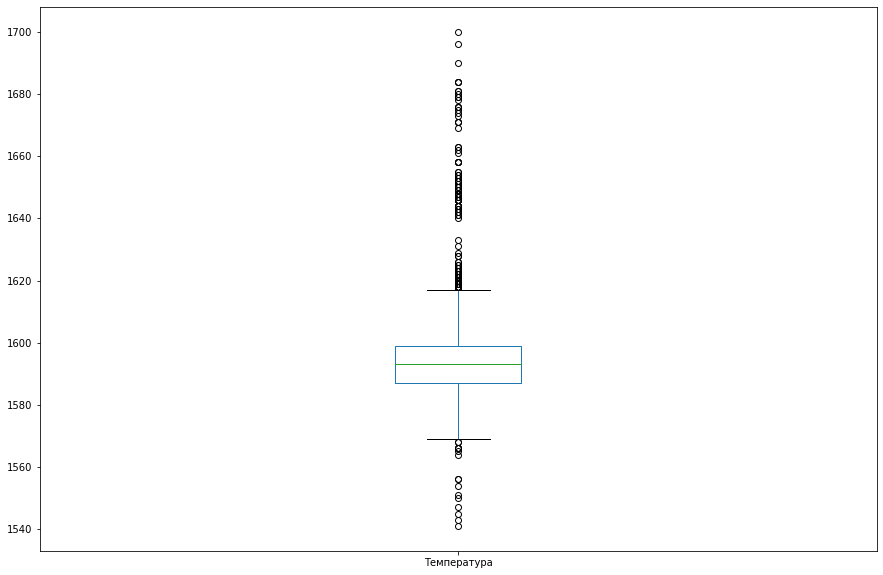

In [60]:
blowouts(data_temp['Температура'])

In [61]:
#q_25 = data_temp.quantile(0.25)['Температура']
#q_75 = data_temp.quantile(0.75)['Температура']

#index_blows = data_temp[['Температура']].query("Температура < @q_75 and Температура > @q_25").index
#data_temp['blowout'] = pd.Series(1,index=index_blows)

In [62]:
#data_temp['blowout'] = pd.Series(1, index=index_blows)
#data_temp['blowout'] = data_temp['blowout'].fillna(0)

Сгруппируем данные и проранжируем их чтобы они соответствовали таблице data_temp

In [63]:
data_arc['rank'] = data_arc['key'].rank(method='first')
max_rank = list(data_arc.groupby(by=['key'])['rank'].agg('max'))
data_arc = data_arc.query("rank in @max_rank")[['key', 'Доля реактивной мощности', 'Разность мощностей']]

## Соединение таблиц

In [64]:
full_data = pd.merge(data_temp, data_arc, how='inner', on=['key'])
full_data = pd.merge(full_data, data_bulk, how='inner', on=['key'])
full_data = pd.merge(full_data, data_wire, how='inner', on=['key'])
full_data = pd.merge(full_data, data_gas, how='inner', on=['key'])

## Проверка мультиколлинеарности

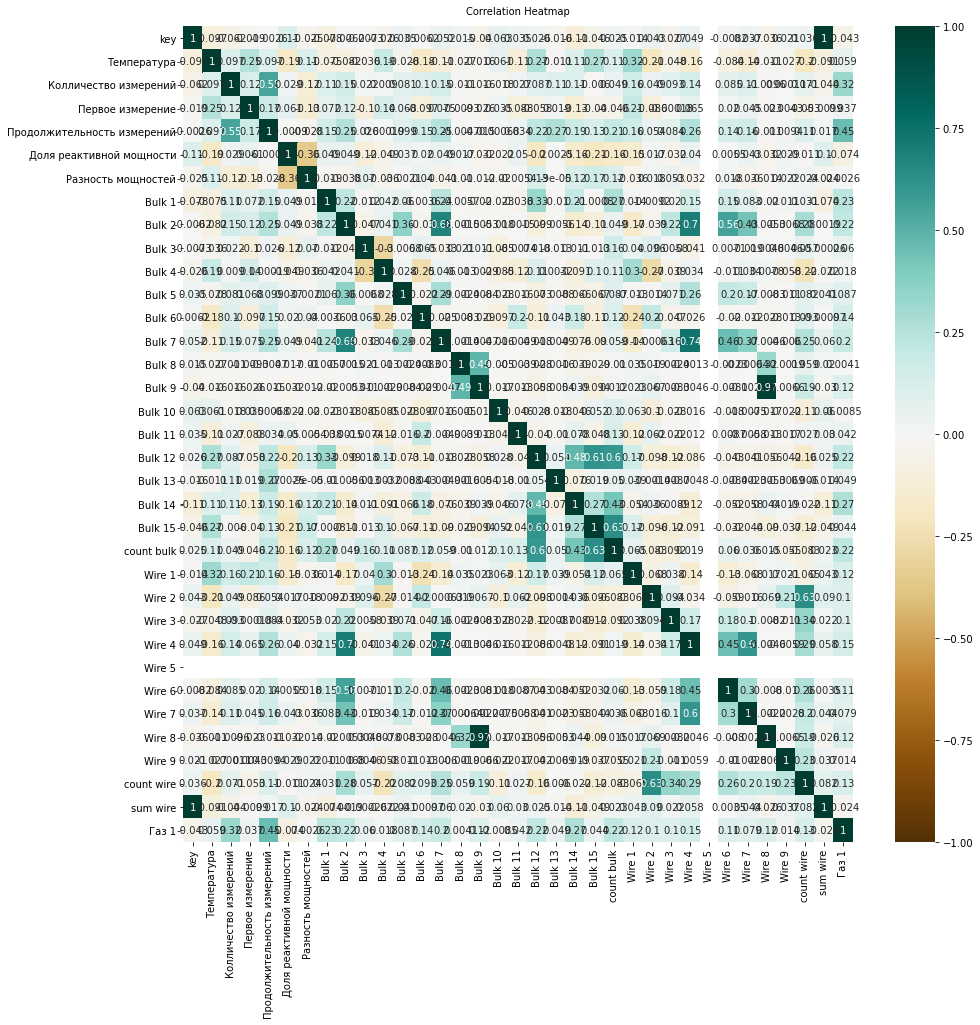

In [65]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(full_data.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
plt.show()

Исходя из таблицы принял решение удалить признаки Bulk 9 и Wire 4, корреляция которых с другими признаками являтя очень высокой и может привести к утечке целевого признака. Удалим признака при подготовки данных для обучения.

Путем дальнейших исследований установили самые влиятельные признаки и так же внесли в колонку те которые вовсе не влияют на результат Bulk 8, Wire 8, Wire 9, Wire 5, count bulk

### Извлечение признаков

In [66]:
features = full_data.drop(columns=['Температура', 'key', 'Bulk 9', 'Wire 4', 
                                   'Bulk 8', 'Wire 8', 'Wire 9', 'Wire 5', 'count bulk'])
target = full_data['Температура']

<AxesSubplot:>

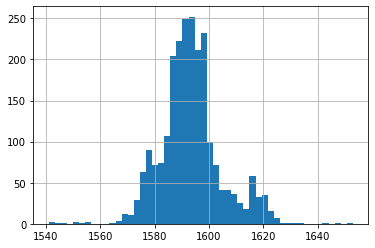

In [67]:
target.hist(bins=50)

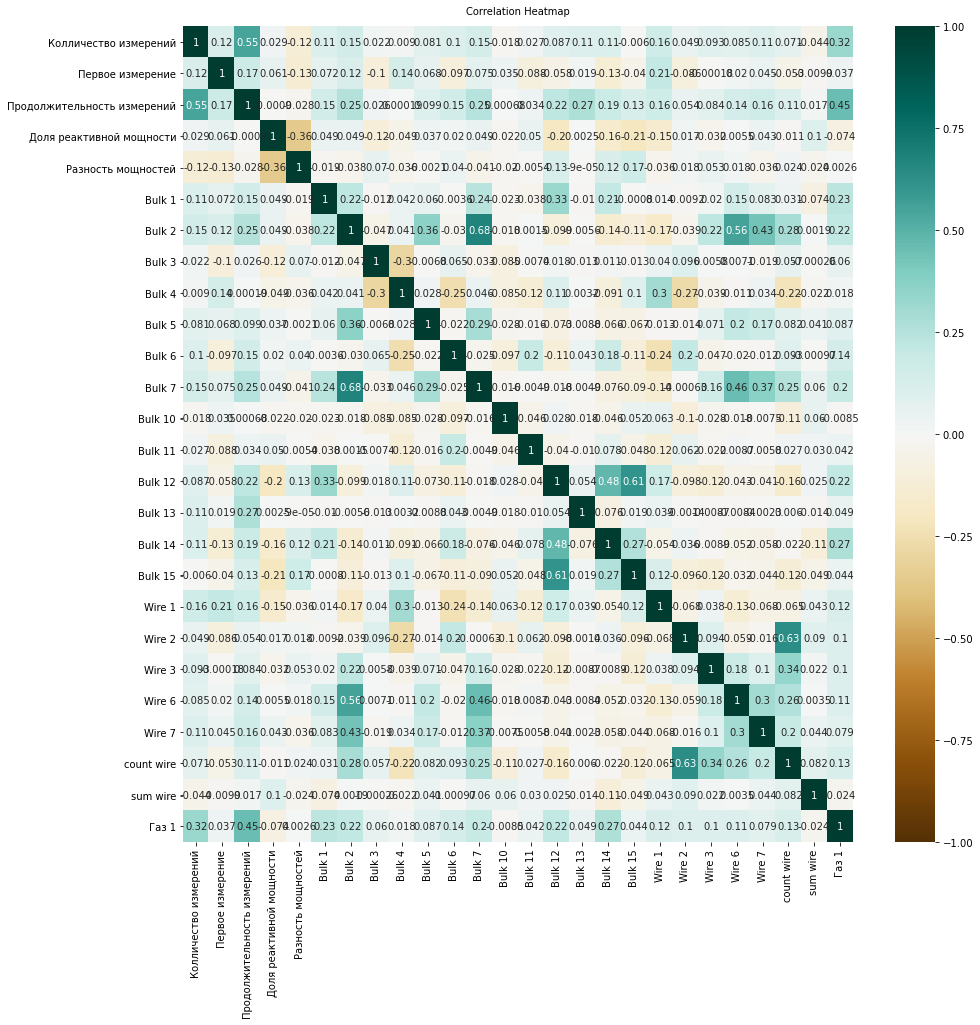

In [68]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
plt.show()

Целевые данные имеют нормальное распределение

In [69]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=SEED)

In [76]:
print(features_train.shape) 
print(features_test.shape)
print(target_train.shape) 
print(target_test.shape)

(1746, 26)
(583, 26)
(1746,)
(583,)


## Вывод 

* Была проведена визуальная оценка данных и составлен план устранения проблем. 

* Общие потери целевого признака составили 22,9%

* Удалены 2 значения выбросов в таблице data_arc.

* Не использованные таблицы **data_bulk_time** и **data_wire_time**

* Сгенерированы следующие признаки:

**data_temp:** Колличество измерений, Продолжительность измерений, blowout(метка выброс/не выброс)

**data_arc:** Доля реактивной мощности, Разность мощностей

**data_wire:** count wire, sum wire

**data_bulk:** count bulk

* Удалены признаки имеющие высокую мультиколлинеарность:

**data_temp:** Колличество измерений, Продолжительность измерений, Первое измерение

**data_arc:** Активная мощность, Реактивная мощность

**data_wire:** Wire 4, Wire 8, Wire 9, Wire 5

**data_bulk:** Bulk 9, Bulk 8, count bulk

* Была построена сборная таблица готовая для подачи на обучение моделям.

# Обучение моделей

## Исследование моделей без подбора гиперпараметров

In [70]:
# создадим датафрейм для сохранения резултатов
df_results_model = pd.DataFrame(columns=["name_model", "MAE", "time_fit", "time_predict"])

In [71]:
# Создадим список моделей для исследования
model_list = [DecisionTreeRegressor(random_state=SEED),
              RandomForestRegressor(random_state=SEED),
              LinearRegression(),
              CatBoostRegressor(random_state=SEED),
              ]
model_list_name = ["DecisionTreeRegressor",
                   "RandomForestRegressor",
                   "LinearRegression",
                   "CatBoostRegressor",
                   ]

In [72]:
def model_test(df_results, model_list, model_list_name, features_train, features_test, target_train, target_test):
    """ Функция для обучения и тестирования моделей из списка моделей, 
    df_results = пустой датафрейм
    model_list = список моделей
    features_train, target_train = обучающие выборки
    features_valid, target_valid = тестовые выборки
    Функция возращает результаты работы моделей - метрика RMSE и время обучения и тестирования модели
    """
    for model in model_list:
        start_fit = time.time()
        model.fit(features_train, target_train)
        end_fit = time.time()
        start_predict = time.time()
        predict = model.predict(features_test)
        end_predict = time.time()
        time_model_fit = end_fit - start_fit
        time_model_predict = end_predict - start_predict
            
                         
        row = {
            "name_model": model,
            "MAE": mean_absolute_error(target_test, predict),
            "time_fit" : time_model_fit,
            "time_predict" : time_model_predict,
            "total_time" : time_model_fit + time_model_predict

        } 

        df_results = df_results.append(row, ignore_index=True)
        
    return df_results

In [74]:
model_test(df_results_model, model_list, model_list_name, features_train, features_test, target_train, target_test)

Learning rate set to 0.044712
0:	learn: 11.1645828	total: 3.41ms	remaining: 3.4s
1:	learn: 11.0540341	total: 6.17ms	remaining: 3.08s
2:	learn: 10.9660805	total: 9.08ms	remaining: 3.02s
3:	learn: 10.8761487	total: 12.2ms	remaining: 3.03s
4:	learn: 10.7994000	total: 14.9ms	remaining: 2.97s
5:	learn: 10.7237984	total: 17.7ms	remaining: 2.93s
6:	learn: 10.6506914	total: 20.4ms	remaining: 2.9s
7:	learn: 10.5725138	total: 23.3ms	remaining: 2.89s
8:	learn: 10.5085298	total: 26ms	remaining: 2.86s
9:	learn: 10.4432991	total: 28.9ms	remaining: 2.86s
10:	learn: 10.3885344	total: 32ms	remaining: 2.87s
11:	learn: 10.3207430	total: 34.8ms	remaining: 2.87s
12:	learn: 10.2681433	total: 37.7ms	remaining: 2.86s
13:	learn: 10.2061020	total: 40.5ms	remaining: 2.85s
14:	learn: 10.1534501	total: 43.4ms	remaining: 2.85s
15:	learn: 10.0991177	total: 46.2ms	remaining: 2.84s
16:	learn: 10.0470522	total: 49ms	remaining: 2.83s
17:	learn: 9.9892914	total: 51.8ms	remaining: 2.82s
18:	learn: 9.9322829	total: 54.6ms	

169:	learn: 7.6736033	total: 528ms	remaining: 2.58s
170:	learn: 7.6632316	total: 533ms	remaining: 2.58s
171:	learn: 7.6604776	total: 537ms	remaining: 2.58s
172:	learn: 7.6524608	total: 540ms	remaining: 2.58s
173:	learn: 7.6452877	total: 544ms	remaining: 2.58s
174:	learn: 7.6437198	total: 546ms	remaining: 2.58s
175:	learn: 7.6382129	total: 549ms	remaining: 2.57s
176:	learn: 7.6293407	total: 552ms	remaining: 2.57s
177:	learn: 7.6228839	total: 555ms	remaining: 2.56s
178:	learn: 7.6154063	total: 558ms	remaining: 2.56s
179:	learn: 7.6094764	total: 561ms	remaining: 2.55s
180:	learn: 7.6023145	total: 564ms	remaining: 2.55s
181:	learn: 7.5914995	total: 567ms	remaining: 2.55s
182:	learn: 7.5890964	total: 569ms	remaining: 2.54s
183:	learn: 7.5830685	total: 572ms	remaining: 2.54s
184:	learn: 7.5766440	total: 575ms	remaining: 2.53s
185:	learn: 7.5703793	total: 579ms	remaining: 2.53s
186:	learn: 7.5665628	total: 581ms	remaining: 2.53s
187:	learn: 7.5605111	total: 584ms	remaining: 2.52s
188:	learn: 

353:	learn: 6.5081665	total: 1.06s	remaining: 1.94s
354:	learn: 6.4953873	total: 1.06s	remaining: 1.94s
355:	learn: 6.4915953	total: 1.07s	remaining: 1.93s
356:	learn: 6.4869776	total: 1.07s	remaining: 1.93s
357:	learn: 6.4728141	total: 1.07s	remaining: 1.93s
358:	learn: 6.4684341	total: 1.08s	remaining: 1.93s
359:	learn: 6.4657643	total: 1.08s	remaining: 1.92s
360:	learn: 6.4651816	total: 1.08s	remaining: 1.92s
361:	learn: 6.4579396	total: 1.09s	remaining: 1.92s
362:	learn: 6.4548954	total: 1.09s	remaining: 1.91s
363:	learn: 6.4434605	total: 1.09s	remaining: 1.91s
364:	learn: 6.4305454	total: 1.09s	remaining: 1.91s
365:	learn: 6.4225707	total: 1.1s	remaining: 1.9s
366:	learn: 6.4163994	total: 1.1s	remaining: 1.9s
367:	learn: 6.4067550	total: 1.1s	remaining: 1.9s
368:	learn: 6.4021460	total: 1.11s	remaining: 1.89s
369:	learn: 6.4011775	total: 1.11s	remaining: 1.89s
370:	learn: 6.3958455	total: 1.11s	remaining: 1.89s
371:	learn: 6.3883663	total: 1.11s	remaining: 1.88s
372:	learn: 6.3868

531:	learn: 5.5816686	total: 1.59s	remaining: 1.4s
532:	learn: 5.5800384	total: 1.6s	remaining: 1.4s
533:	learn: 5.5749812	total: 1.6s	remaining: 1.4s
534:	learn: 5.5674008	total: 1.61s	remaining: 1.4s
535:	learn: 5.5616763	total: 1.61s	remaining: 1.39s
536:	learn: 5.5606853	total: 1.61s	remaining: 1.39s
537:	learn: 5.5554671	total: 1.61s	remaining: 1.39s
538:	learn: 5.5493647	total: 1.62s	remaining: 1.38s
539:	learn: 5.5464006	total: 1.62s	remaining: 1.38s
540:	learn: 5.5460078	total: 1.62s	remaining: 1.38s
541:	learn: 5.5416196	total: 1.63s	remaining: 1.37s
542:	learn: 5.5388911	total: 1.63s	remaining: 1.37s
543:	learn: 5.5343720	total: 1.63s	remaining: 1.37s
544:	learn: 5.5288317	total: 1.63s	remaining: 1.36s
545:	learn: 5.5255788	total: 1.64s	remaining: 1.36s
546:	learn: 5.5217749	total: 1.64s	remaining: 1.36s
547:	learn: 5.5179907	total: 1.64s	remaining: 1.35s
548:	learn: 5.5129535	total: 1.65s	remaining: 1.35s
549:	learn: 5.5098303	total: 1.65s	remaining: 1.35s
550:	learn: 5.5050

714:	learn: 4.8189746	total: 2.13s	remaining: 848ms
715:	learn: 4.8167578	total: 2.13s	remaining: 846ms
716:	learn: 4.8096723	total: 2.14s	remaining: 843ms
717:	learn: 4.8089414	total: 2.14s	remaining: 840ms
718:	learn: 4.8058033	total: 2.14s	remaining: 837ms
719:	learn: 4.7998728	total: 2.15s	remaining: 834ms
720:	learn: 4.7932082	total: 2.15s	remaining: 831ms
721:	learn: 4.7913511	total: 2.15s	remaining: 828ms
722:	learn: 4.7868088	total: 2.15s	remaining: 825ms
723:	learn: 4.7857947	total: 2.16s	remaining: 822ms
724:	learn: 4.7804239	total: 2.16s	remaining: 819ms
725:	learn: 4.7743973	total: 2.16s	remaining: 816ms
726:	learn: 4.7704550	total: 2.17s	remaining: 813ms
727:	learn: 4.7695242	total: 2.17s	remaining: 810ms
728:	learn: 4.7673733	total: 2.17s	remaining: 807ms
729:	learn: 4.7642977	total: 2.17s	remaining: 804ms
730:	learn: 4.7632683	total: 2.18s	remaining: 802ms
731:	learn: 4.7577851	total: 2.18s	remaining: 799ms
732:	learn: 4.7516138	total: 2.18s	remaining: 796ms
733:	learn: 

893:	learn: 4.2064702	total: 2.66s	remaining: 316ms
894:	learn: 4.2038124	total: 2.67s	remaining: 313ms
895:	learn: 4.1998947	total: 2.67s	remaining: 310ms
896:	learn: 4.1963500	total: 2.67s	remaining: 307ms
897:	learn: 4.1909697	total: 2.67s	remaining: 304ms
898:	learn: 4.1907625	total: 2.68s	remaining: 301ms
899:	learn: 4.1856017	total: 2.68s	remaining: 298ms
900:	learn: 4.1803964	total: 2.68s	remaining: 295ms
901:	learn: 4.1783027	total: 2.69s	remaining: 292ms
902:	learn: 4.1748214	total: 2.69s	remaining: 289ms
903:	learn: 4.1711573	total: 2.69s	remaining: 286ms
904:	learn: 4.1672686	total: 2.69s	remaining: 283ms
905:	learn: 4.1669388	total: 2.7s	remaining: 280ms
906:	learn: 4.1632060	total: 2.7s	remaining: 277ms
907:	learn: 4.1590787	total: 2.7s	remaining: 274ms
908:	learn: 4.1544212	total: 2.71s	remaining: 271ms
909:	learn: 4.1520419	total: 2.71s	remaining: 268ms
910:	learn: 4.1505768	total: 2.71s	remaining: 265ms
911:	learn: 4.1459986	total: 2.71s	remaining: 262ms
912:	learn: 4.1

name_model       MAE  time_fit  \
0       DecisionTreeRegressor(random_state=20220809)  9.346484  0.062831   
1  (DecisionTreeRegressor(max_features='auto', ra...  6.629125  1.502080   
2                                 LinearRegression()  7.071409  0.001995   
3  <catboost.core.CatBoostRegressor object at 0x0...  6.727010  3.172906   

   time_predict  total_time  
0      0.003989    0.066820  
1      0.019947    1.522027  
2      0.001995    0.003989  
3      0.001995    3.174902

Text(0.5, 0, 'CatBoost Feature Importance')

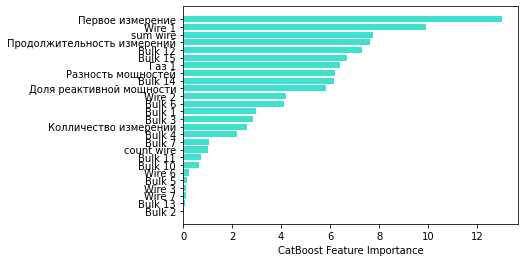

In [75]:
sorted_feature_importance = model_list[3].feature_importances_.argsort()
plt.barh(features.columns[sorted_feature_importance],
        model_list[3].feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

[Продолжительность измерений, sum wire, Разность мощностей, доля реактивной мощности, количество измерений(температуры), count wire]

## Подбор гиперпараметров

In [238]:
def objective_cat(trial, X, y):
    param = {
         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03),
         "max_depth": trial.suggest_int('max_depth', 3, 12),
         "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
         "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'loss_function': 'MAE'      
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    cv_predicts = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
        model = CatBoostRegressor(**param, random_seed=SEED)
    
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100,
                  use_best_model=True,
                  verbose=2)
        preds = model.predict(X_test)        
        cv_predicts[idx] = mean_absolute_error(y_test, preds)   
    
    
    
    return np.mean(cv_predicts)

callbacks - класс обратного вызова, может обнаруживать бесперспективные наборы гиперпараметров перед обучением, тем самым значительно сокращая время поиска

In [239]:
study_cat = optuna.create_study(direction="minimize", study_name="CatBoostRegressor")
func_cat = lambda trial: objective_cat(trial, features_train, target_train)

study_cat.optimize(func_cat, n_trials=10, show_progress_bar=True)

[I 2022-08-17 00:50:27,162] A new study created in memory with name: CatBoostRegressor
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 8.2391147	test: 7.8000194	best: 7.8000194 (0)	total: 7.85ms	remaining: 7.84s
2:	learn: 8.2309147	test: 7.7954423	best: 7.7954423 (2)	total: 20ms	remaining: 6.66s
4:	learn: 8.2220786	test: 7.7916646	best: 7.7916646 (4)	total: 30.6ms	remaining: 6.09s
6:	learn: 8.2138154	test: 7.7859391	best: 7.7859391 (6)	total: 41.7ms	remaining: 5.91s
8:	learn: 8.2048335	test: 7.7816015	best: 7.7816015 (8)	total: 51.5ms	remaining: 5.67s
10:	learn: 8.1954519	test: 7.7758702	best: 7.7758702 (10)	total: 61ms	remaining: 5.48s
12:	learn: 8.1867175	test: 7.7701990	best: 7.7701990 (12)	total: 70.6ms	remaining: 5.36s
14:	learn: 8.1766812	test: 7.7643219	best: 7.7643219 (14)	total: 80.4ms	remaining: 5.28s
16:	learn: 8.1673289	test: 7.7602016	best: 7.7602016 (16)	total: 90.1ms	remaining: 5.21s
18:	learn: 8.1597460	test: 7.7561008	best: 7.7561008 (18)	total: 99.5ms	remaining: 5.14s
20:	learn: 8.1522590	test: 7.7527172	best: 7.7527172 (20)	total: 109ms	remaining: 5.07s
22:	learn: 8.1437078	test: 7.7480291

Лучший скорр (после добавления sum wire, count bulk, count wire) 6.80351

Лучший скорр (после добавления blowouts) 5.78920

In [240]:
print(f"\tBest value (MAE): {study_cat.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_cat.best_params.items():
    print(f"\t\t{key}: {value}")


	Best value (MAE): 6.70636
	Best params:
		learning_rate: 0.02927980898699095
		max_depth: 6
		l2_leaf_reg: 3.0
		min_child_samples: 1


In [241]:
study_cat.best_params

{'learning_rate': 0.02927980898699095,
 'max_depth': 6,
 'l2_leaf_reg': 3.0,
 'min_child_samples': 1}

	Best value (MAE): 6.70636
	Best params:
		learning_rate: 0.02927980898699095
		max_depth: 6
		l2_leaf_reg: 3.0
		min_child_samples: 1

<ipython-input-242-c1b2bcf229e6>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_cat);


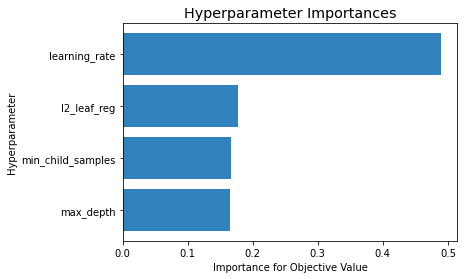

In [242]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study_cat);

In [243]:
model_test = CatBoostRegressor(**study_cat.best_params, random_seed=SEED)
model_test.fit(features_train,
                  target_train,
                  early_stopping_rounds=100,
                  use_best_model=True
                  )
preds = model_test.predict(features_test)        
MAE_test = mean_absolute_error(target_test, preds)   

print(f'Резултьтат MAE на тестовой выборке:{MAE_test}')

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 11.2008490	total: 3.24ms	remaining: 3.23s
1:	learn: 11.1268047	total: 6.39ms	remaining: 3.19s
2:	learn: 11.0667031	total: 9.55ms	remaining: 3.17s
3:	learn: 11.0047022	total: 13.1ms	remaining: 3.26s
4:	learn: 10.9511777	total: 16.4ms	remaining: 3.26s
5:	learn: 10.8964264	total: 19.3ms	remaining: 3.2s
6:	learn: 10.8413158	total: 22.3ms	remaining: 3.16s
7:	learn: 10.7844490	total: 25.4ms	remaining: 3.15s
8:	learn: 10.7368273	total: 29ms	remaining: 3.19s
9:	learn: 10.6883879	total: 31.9ms	remaining: 3.15s
10:	learn: 10.6463715	total: 34.9ms	remaining: 3.14s
11:	learn: 10.5946560	total: 38ms	remaining: 3.13s
12:	learn: 10.5534106	total: 41ms	remaining: 3.11s
13:	learn: 10.5032856	total: 44.3ms	remaining: 3.12s
14:	learn: 10.4597446	total: 47.9ms	remaining: 3.14s
15:	learn: 10.4171382	total: 50.8ms	remaining: 3.13s
16:	learn: 10.3767174	total: 54.2ms	remaining: 3.13s
17:	learn: 10.3319441	total: 57.8ms	remaining: 3.15s
18:	learn: 10.2881974	total: 60.8ms	remaining: 3.14s
19:	learn:

In [244]:
print(MAE_test)

6.613141012556192


**ИТОГОВЫЙ РЕЗУЛЬТАТ MAE *6.6131***

# Отчёт по проекту "Прогнозирование температуры стали"

## Описание и данные

Данные предоставлены металлургическим комбинатом ООО «Так закаляем сталь» бизнес задачей которых стояло снизит затраты на энергопотребление.

Представленные данные были представлены в виде на 6 датафреймов:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Данные соеденены между собой первичным ключём, колонка `key`. Колонки `data_temp` и `data_arc` содержат итеративные данные процедуры нагрева: активная и реактивная энергия (data_arc), время измерения и температура ковша (data_temp). Ключи в остальные данные соответствуют соответствующему ковшу.

**Цель исследования:** Нам необходимо снизить затраты энергоресурсов за счёт увеличения эффективности нагрева графитовыми электродами.

Задача решается путем создания модели машинного обучения, предсказывающем итоговую температуру ковша. Зная эти данные можно заранее предупредить недостаток температуры путем проведения соответствующих манипуляций с ковшом.

## Подготовка данных и исследовательский анализ

В ходе исследований в данных были выявлены следующие проблемы:

* Таблицы data_bulk, data_bulk_time, data_wire, data_wire_time в силу своей специфики содержат большое количество пропусков, т.к. примеси в виде сыпучих и проволочны материалах добавлялись по необходимости и только конкретные их виды, от чего количество пропусков в конкретной колонке могло достигать 99.9%

**Решение:** Колонки с 0 несли в себе минимум информации и были удалены. Порог удаления выбран менее 30% пропусков. Этот порог позволил удалить все данные которые невозможно предобработать и получить из них ценную информацию.

* Обработка остальных пропусков в данных.

**Решение:** 

**data_temp**. Пропуски удалены в случае если это не последнее измерение. т.к. последнее измерение по партии. Иные преобразования невозможны т.к. этот признак содержит в себе целевую переменную и менять её нельзя. Итоговые потери 22,9% данных.

**data_bulk**. Пропуски заменены 0. Это значит что конкретно взятая примесь не добавлялась.

**data_wire**. Пропуски заменены 0. Это значит что конкретно взятая примесь не добавлялась.

**data_bulk_time**. Колонка удалены, т.к. анализ временного ряда в данной работе не имеет смысла.

**data_wire_time**. Колонка удалены, т.к. анализ временного ряда в данной работе не имеет смысла.

* Обработка выбросов в данных.

**data_arc** Были найдены 2 критических значения в активная мощность 3,5 и реактивная мощность -700. Если с -700 все понятно, оцевидная ошибка и выброс, то с активной мощностью все не так однозначно. Было принято решение избавиться только от одного значения и оставить все остальные данные, даже те что лежат за пределами 1 и 3 квантилей, т.к. данный разброс может быть обусловлен производственными нормами. Сохранение "выбросов" в данной колонке.

**data_temp** Была предпринята попытка промаркировать создать колонку с бинарной классификацией выбросы колонки `Температура`, но от этой идеии пришлось отказаться, т.к. при моделировании наблюдается явная утечка целевого признака, а так же данный признак не является интерпретируемым.

* Генерация признаков

**data_temp**

Колличество измерений - количество измерений сгенерировано из мысли о том что количество измерений состоит из нескольких внутренних составляющих: добавление новой примеси, нагрев, время между этими этапами. Влияние на количество измерений не только продолжительности можно увидеть на матрице корреляций. Корреляция этих двух признаков составляет 0.55.

Первое измерение - Первая температура по партии. Помогает не в слепую предсказывать значение будущей температура, а уже иметь некоторые уровни поддержки или сопротивления отталкиваясь от которых можно лучше предсказать итоговую температуру.

Продолжительность измерений - чем дольше дольше протекает процесс переправки тем больше наши погрешности в измерениях, тем чаще нужно нагревать ковш. Этот фактор нужно учитывать.

**data_arc**

Доля реактивной мощности, Разность мощностей - Синтетическиe данные созданные для того чтобы избавиться от лишних корреляций признаков `Активная мощность` и `Реактивная мощность`, но при этом сохранить их влияние на процесс.

Доля реактивной мощности получена из суммы затраченных мощностей.

**data_bulk**

count bulk - количество добавлений примесей. Ранее мы уже определили что время измерений косвено зависит от количества добавлений примесей.

**data_wire**

count wire - количество добавлений примесей.

sum wire - сумма всех добавленных примесей.

* Корреляция и мультиколлинеарность

Исходя из графика корреляции принял решение удалить признаки Bulk 9 и Wire 4, корреляция которых с другими признаками являтя очень высокой и может привести к утечке целевого признака. Путем дальнейших исследований установили самые влиятельные признаки и так же внесли в колонку те которые вовсе не влияют на результат Bulk 8, Wire 8, Wire 9, Wire 5, count bulk.

Во время исследовательского процесса так же были составлены признаки которые не вошли в итоговую таблицу в силу сильной мультиколлинеарности. Напирмер: Полная мощность, сумма сыпучих материалов, доля активной мощности, активная мощностью.


**Все пункты исследовательского анализа были выполнены**

Общие потери целевого признака составили 22,9%.

Удалены 2 значения выбросов в таблице **data_arc**.

Не использованные таблицы **data_bulk_time** и **data_wire_time**.

Сгенерированы новые признаки.

Удалены признаки имеющие высокую мультиколлинеарность.

Была построена сборная таблица **full_data** готовая для подачи на обучение моделям.

## Выбор модели обучения

При подготовке к обучению было установлено что целевая переменная имеет нормальное распределение и в преобразованиях и манипуляциях не нуждается.

Размерность полной таблицы составило 2329 строк и 26 признаков включая целевой признак.

**Размерность тренировочной выборки**

X = (1746, 26)

y = (1746)

**Размер тестовой выборки**

X = (583, 26)

y = (583)

Первым шагом было обучить модель на "голых" моделях чтобы примерно представлять какие из них стоит выбрать для дальнейшего подбора гиперпараметров, а также установить силу влияния признаков на точность обучения.

Для тестирования были выбраны модели `DecisionTreeRegressor`, `RandomForestRegressor`, `LinearRegression` и `CatBoostRegressor`. Результаты приведены ниже.

<table border="1">
   <tr>
    <th></th>
    <th>MAE</th>
    <th>time_fit</th>
    <th>time_predict</th>
    <th>total_time</th>
   </tr>
   <tr>
    <th>DecisionTreeRegressor</th>
    <td>9.346484</td>
    <td>0.062831</td>
    <td>0.003989</td>
    <td>0.066820</td>
  </tr>
       <tr>
    <th>RandomForestRegressor</th>
    <td>6.629125</td>
    <td>1.502080</td>
    <td>0.019947</td>
    <td>1.522027</td>
  </tr>
       <tr>
    <th>LinearRegression</th>
    <td>7.071409</td>
    <td>0.001995</td>
    <td>0.001995</td>
    <td>0.003989</td>
  </tr>
       <tr>
    <th>CatBoostRegressor</th>
    <td>6.727010</td>
    <td>3.172906</td>
    <td>0.001995</td>
    <td>3.174902</td>
  </tr>

</table>

![Важность признаков](https://imageup.ru/img219/thumb/screenshot_164002447.jpg?nc)

Отталкиваясь от этих результатов мы видим что самую высокую точность показал случайный лес но разница незначительная, по этому остановились на подборе гиперпараметров для CatBoostRegressor, т.к. они гораздо более поддатливы к настройкам и как правило из модели бустинга можно выжать лучшие результаты.

Подбор гиперпараметров выполнялся с помощью фреймворка optuna. Первичный диапазон гиперпараметров:

* "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03)
         
* "max_depth": trial.suggest_int('max_depth', 3, 12)
         
* "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
         
* "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])

Наиболее влияющими параметров на модель стал learning_rate. Остальные представители сетки параметров внесли примерно равный вклад в улучшение точности.

![Важность гиперпараметров](https://imageup.ru/img56/thumb/vazhnost-priznakov4002446.jpg?nc)

Лучший результат `МАЕ` при подборе параметров - `6.7063`

Лучшие параметры:

* learning_rate: 0.02927980898699095

* max_depth: 6

* l2_leaf_reg: 3.0

* min_child_samples: 1

Далее была обучена новая модель CatBoost с подобраными параметрами. На тестовой выборке значение `MAE` составила `6.6131`, что при средней температуре в 1300-1500 градусов очень хорошо.

## Общие вопросы

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Были выполнены все ранее заявленные пункты. Не удалось избавиться от выбросов в таблицах data_arc и data_temp в силу отсутствия информации о нормах производственного процесса.

**Какие трудности возникли и как вы их преодолели?**

Трудность с подбором и генерацией статистически значимых признаков и отсутствием у них мультиколлинеарности. Признаки подбирались эксперементальным путём, а генерировались на основах математики, статистики и логики. Какие-то задумки оказались успешными, а ряд признаков которые вносили сильную корреляцию были удалены.

Так же сложность возникла с настройкой датафрейма optuna. Изучение соответствующих статей и примеров кода помогли разобраться и эффективно использовать технологию.

**Какие ключевые шаги в решении задачи выделили?**

Основным шагом был поиск скрытых закономерностей и для генерации новых признаков, которые и служили основой высокого качества итоговой 

**Какая ваша итоговая модель и какое у неё качество?**

Лучшей моделью на тестировании стала **CatBoostRegressor** с параметрами:

* "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03)

* "max_depth": trial.suggest_int('max_depth', 3, 12)

* "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)

* "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])

**Метрика МАЕ = 6.6131**